https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
from google.colab import output
#Install Keras-tuner on first run.
!pip install keras-tuner
# install the ydata-profiling package
!pip install ydata-profiling
#Mount google drive on first run
from google.colab import drive
drive.mount('/content/drive')
#Clear cell output
output.clear() #Clears output after installing packages. Hide if any issues.

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

#  Import and read the charity_data.csv.
url = "drive/MyDrive/BootCamp/project_4/Resources/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

#Import python auto EDA
# load the ydata_profiling package
from ydata_profiling import ProfileReport

#drop id column
df = df.drop(columns=['id'])



In [3]:
#preliminary changes to format categorical columns and drop id.
#create backup of original df
df_backup = df.copy()
# List of feature names to convert to categorical
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'stroke', 'work_type', 'Residence_type']

# Convert the selected features to categorical
df[categorical_features] = df[categorical_features].astype('category')



#Create AutoEDA report

In [4]:
# use ProfileReport
pr_df = ProfileReport(df)
# show pr_df
pr_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Cleaning Data

In [5]:
#Check to see how many values are NaN in BMI and if it disproportonatley affects stroke records
bmi_nan_df = df[df['bmi'].isna()]
bmi_nan_df

# Count the number of rows where 'stroke' is 1
stroke_1_count = bmi_nan_df['stroke'].eq(1).sum()

# Calculate the percentage
percentage_with_stroke_1 = (stroke_1_count / len(bmi_nan_df)) * 100

print(f'Total rows with stroke = 1 and bmi = NaN: {stroke_1_count}')
print(f"Percentage of rows with 'stroke' = 1 in filtered_df: {percentage_with_stroke_1:.2f}%")

# Count the number of rows where 'stroke' is 1 in the original DataFrame
stroke_1_count_original = df['stroke'].eq(1).sum()

# Calculate the percentage
percentage_with_stroke_1_original = (stroke_1_count_original / len(df)) * 100

print(f"Percentage of rows with 'stroke' = 1 in the original df: {percentage_with_stroke_1_original:.2f}%")

Total rows with stroke = 1 and bmi = NaN: 40
Percentage of rows with 'stroke' = 1 in filtered_df: 19.90%
Percentage of rows with 'stroke' = 1 in the original df: 4.87%


Records for stroke sufferers seem to be disproprotionately represented in rows missing bmi. This will need to be dealt with some how.

In [6]:
#No duplicated columns founr
df.duplicated().sum()

0

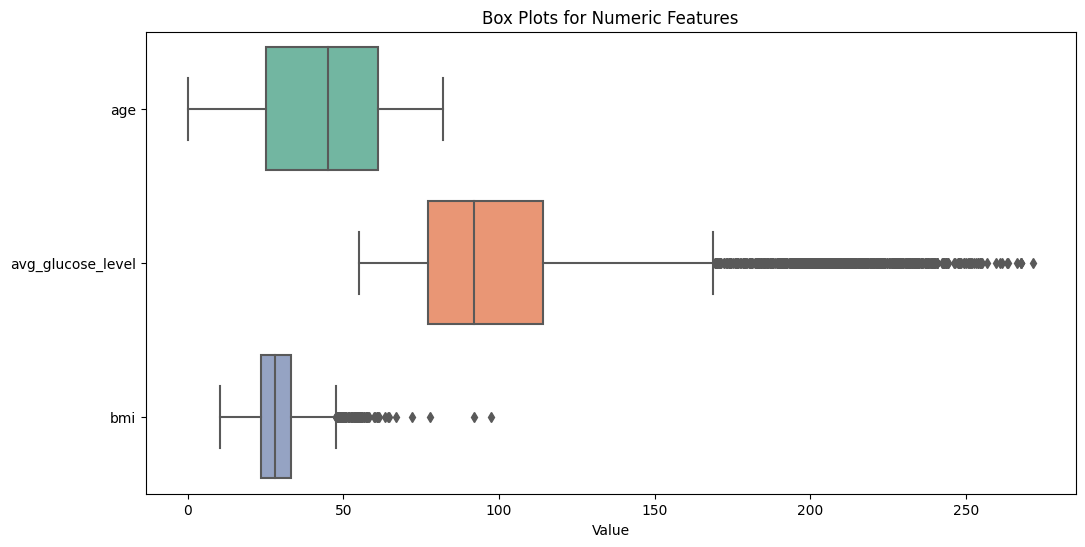

In [7]:
# Filter only the numeric columns
numeric_df = df.select_dtypes(include=['number'])
# Create box plots for all numeric features
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df, orient='h', palette='Set2')
plt.title("Box Plots for Numeric Features")
plt.xlabel("Value")
plt.show()

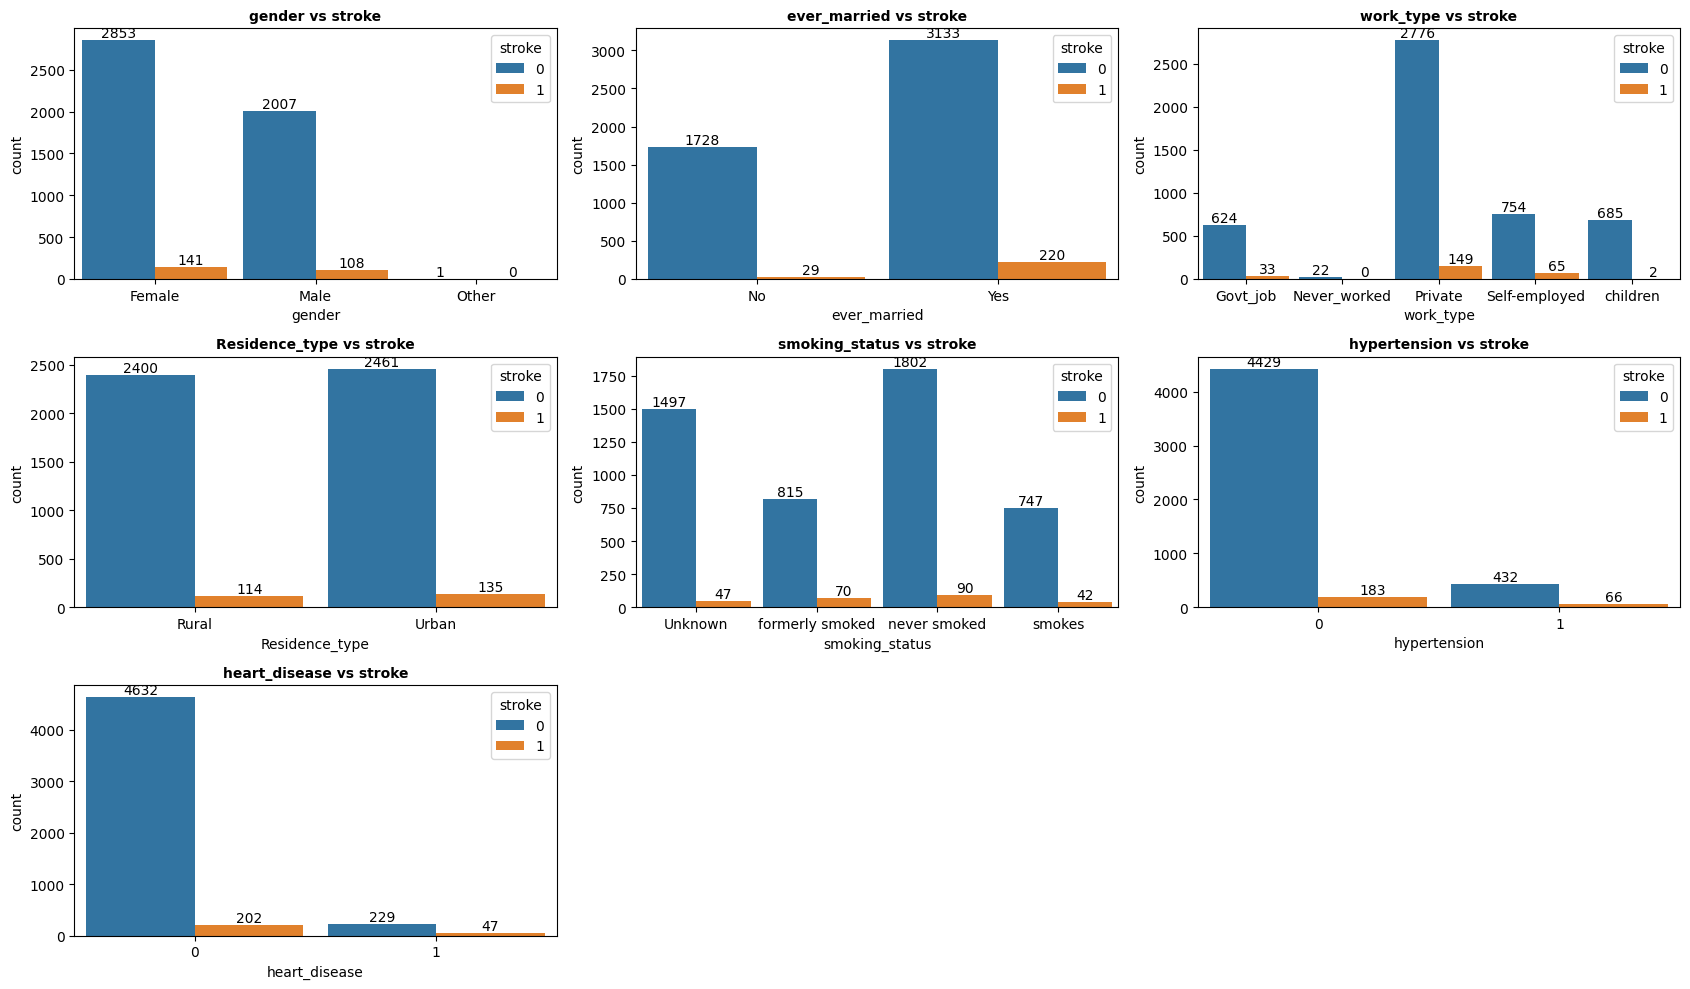

In [8]:
column_list=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','hypertension','heart_disease']

plt.figure(figsize=(17,10))
for i, cols in enumerate(column_list):
  plt.subplot(3,3,i+1)
  ax=sns.countplot(data=df, x=cols ,hue="stroke", width=0.9)
  for bars in ax.containers:
    ax.bar_label(bars)
  plt.title(f"{cols} vs stroke", size=10, fontweight="black")
plt.tight_layout()
plt.show()

<ipython-input-9-25578b1ba9bb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_backup.corr()


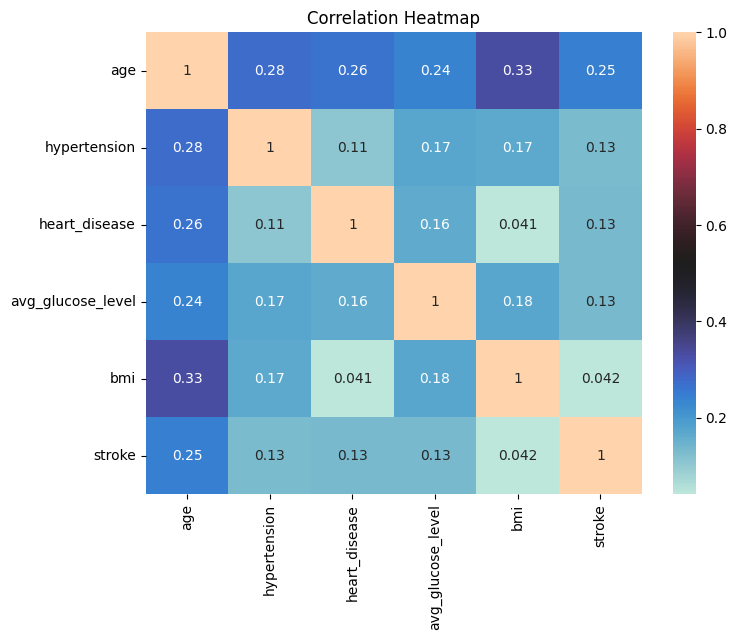

In [9]:
# Calculate the correlation matrix
corr = df_backup.corr()

# Create the heatmap with annotations
cmap = 'icefire'
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap=cmap)
plt.title("Correlation Heatmap")
plt.show()

<ipython-input-10-ca6e742a15ba>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rel_stroke = df_backup.corr()["stroke"].sort_values(ascending=False)


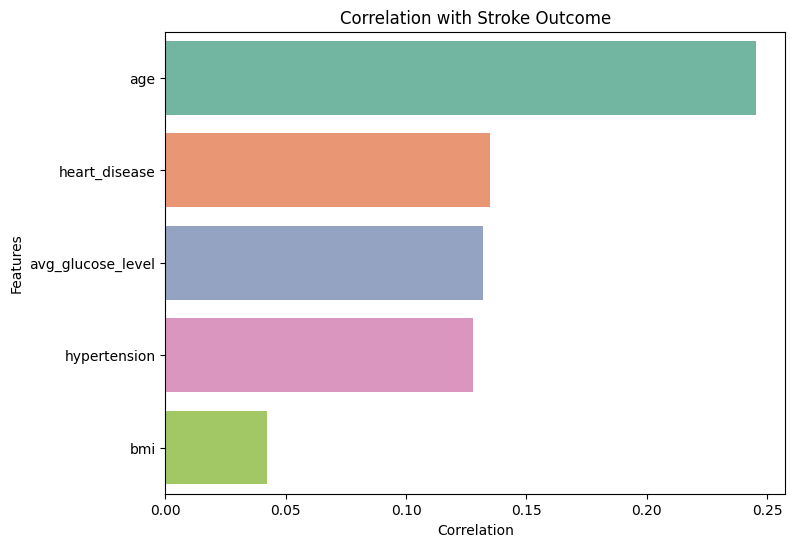

In [10]:
# Calculate the correlations with "stroke" outcome
rel_stroke = df_backup.corr()["stroke"].sort_values(ascending=False)

# Drop the "stroke" feature itself from rel_stroke
rel_stroke = rel_stroke.drop("stroke")

# Visualise the correlation
plt.figure(figsize=(8, 6))
sns.barplot(x=rel_stroke.values, y=rel_stroke.index, palette="Set2")
plt.title("Correlation with Stroke Outcome")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.show()

Age seems to be the feature most highly correlatd with stroke risk. BMI less so, which is promising as there is many missing BMI values

# Data Cleaning

In [4]:
#Need to deal with NaN BMI
#creating new DF with values replaced with mean
df_clean = df.copy()
df_clean = df_clean.drop(columns = ['bmi'])

Encode labels with label encoder.

In [12]:
#set encoder
encoder = LabelEncoder()

#create copy of dataset for encoding to leave for other methods.
df_clean_encoded = df_clean.copy()

# Features to apply label encoding to
features_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Loop through the features and apply label encoding
for feature in features_to_encode:
    df_clean_encoded[feature] = encoder.fit_transform(df_clean_encoded[feature])

# Display the modified DataFrame
df_clean_encoded.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [13]:
#Create target and datset from cleaned data
y = y=df_clean_encoded["stroke"]
X=df_clean_encoded.drop(["stroke"], axis=1)

In [14]:
#Scale features with standard scaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [15]:
#split model
X_train,X_test,y_train,y_test=train_test_split(X_scaled, y, test_size=0.2,random_state=45)


In [16]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier = RandomForestClassifier(random_state=40, n_jobs=-1, n_estimators=10)
# Training a Classifier
RandomForestClassifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=40)

In [17]:
predict = RandomForestClassifier.predict(X_test)
print(classification_report(y_test, predict))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       976
           1       0.17      0.02      0.04        46

    accuracy                           0.95      1022
   macro avg       0.56      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



#Hyperparameter tuning attempt on RandomForest

In [21]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=40, n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',  # Use an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

# Perform hyperparameter tuning on your data (X_train, y_train)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_classifier = random_search.best_estimator_

Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}


In [22]:
predict = best_rf_classifier.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       976
           1       0.00      0.00      0.00        46

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.91      0.95      0.93      1022



In [24]:
# Define the path to the Google Drive directory where you want to save your model
drive_path = '/content/drive/MyDrive/BootCamp/project_4/'  # Update "Your_Folder" with your desired folder name

# Save the model to the specified path
model_filename = 'stroke_data_decision_tree_model.pkl'  # Replace "your_model_name" with your model's name and extension
joblib.dump(best_rf_classifier, drive_path + model_filename)

['/content/drive/MyDrive/BootCamp/project_4/stroke_data_decision_tree_model.pkl']